In [139]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table, join

from astropy.io import ascii
import glob, re

% matplotlib inline

import matplotlib as mpl
mpl.style.use('seaborn-colorblind')

#To make sure we have always the same matplotlib settings
#(the ones in comments are the ipython notebook settings)

mpl.rcParams['figure.figsize']=(8.0,6.0)    #(6.0,4.0)
mpl.rcParams['font.size']=18               #10 
mpl.rcParams['savefig.dpi']= 200             #72 
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12


In [140]:
fname_spc = '../data/spc_giants.csv' # original
fname_spc = '../data/smear_spc_new.txt' # updated 
fname_spc = '../data/SMEAR_SPC_first_iteration.txt' # new targets
fname_spc = '../data/smear_spc_2.txt' # new targets 
fname_spc = '../data/SMEAR_reiterated.txt'

fname_guy = '../data/smear_Dnu.csv' 

In [141]:
spc_data = Table.read(fname_spc,format='ascii')

guy_data = Table.read(fname_guy,format='ascii')
guy_data.rename_column('Star_ID','Object')
print guy_data.keys()
print spc_data.keys()

['Object', 'Dnu', 'Dnu_err', 'Numax', 'Numax_err', 'eps', 'eps_err']
['Object', 'BJD_TDB', 'RV', 'RVerr', 'Teff', 'Teff_err', 'logg', 'logg_err', 'monh', 'monh_err', 'vsini', 'vsini_err', 'CCF', 'SNRe', 'n_aps', 'exptime', 'spectro', 'res', 'method']


In [142]:
spc_data

Object,BJD_TDB,RV,RVerr,Teff,Teff_err,logg,logg_err,monh,monh_err,vsini,vsini_err,CCF,SNRe,n_aps,exptime,spectro,res,method
str10,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,str4,str1,str6
BD+43_3171,2457671.586446,-16.325,0.11,3655.87,50,1.137,0.1,-1.203,0.08,4.54,0.5,0.992,68.9,3,250.0,tres,m,SPC2.9
HD_174020,2457670.580448,-14.835,0.077,3780.53,50,1.24,0.1,-1.033,0.08,5.38,0.5,0.9832,120.1,3,200.0,tres,m,SPC2.9
HD_180682,2457672.569455,30.986,0.071,4076.96,50,1.429,0.1,-1.034,0.08,5.75,0.5,0.9792,80.1,3,80.0,tres,m,SPC2.9
HD_181022,2457647.609269,-80.388,0.16,3556.71,50,1.032,0.1,-1.63,0.08,4.68,0.5,1.0026,108.8,3,120.0,tres,m,SPC2.9


In [143]:
new_stars = ['HD_175466','BD+42_3150','BD+48_2904','HD_176209','HD_182354','HD_189636B','HD_189636A','HD_189750']

In [144]:
for star in new_stars:
    if star in guy_data['Object']:
        print star

BD+42_3150
BD+48_2904
HD_176209
HD_182354
HD_189750


In [145]:
guy_data.sort('Object')
spc_data.sort('Object')

In [146]:
spc_data

Object,BJD_TDB,RV,RVerr,Teff,Teff_err,logg,logg_err,monh,monh_err,vsini,vsini_err,CCF,SNRe,n_aps,exptime,spectro,res,method
str10,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,str4,str1,str6
BD+43_3171,2457671.586446,-16.325,0.11,3655.87,50,1.137,0.1,-1.203,0.08,4.54,0.5,0.992,68.9,3,250.0,tres,m,SPC2.9
HD_174020,2457670.580448,-14.835,0.077,3780.53,50,1.24,0.1,-1.033,0.08,5.38,0.5,0.9832,120.1,3,200.0,tres,m,SPC2.9
HD_180682,2457672.569455,30.986,0.071,4076.96,50,1.429,0.1,-1.034,0.08,5.75,0.5,0.9792,80.1,3,80.0,tres,m,SPC2.9
HD_181022,2457647.609269,-80.388,0.16,3556.71,50,1.032,0.1,-1.63,0.08,4.68,0.5,1.0026,108.8,3,120.0,tres,m,SPC2.9


In [147]:
numax_sun = 3160.
numax_sun_err = 10.

Teff_sun = 5777.
logg_sun = 4.43812

In [148]:
mapping = np.array([np.where(guy_data['Object'][:]==obj)[0][0] for obj in spc_data['Object'] if (obj in guy_data['Object'])])
missing = np.array([obj not in guy_data['Object'] for obj in spc_data['Object']])

In [149]:
# new_table = join(guy_data[mapping],spc_data[~missing])
new_table = join(guy_data,spc_data)

In [150]:
# spc_data['Object'].pprint(max_lines=70)

In [151]:
# new_table.keys()

In [152]:
g = ((new_table['Teff']/Teff_sun)**0.5) * (new_table['Numax']/numax_sun)
log_g = np.log10(g)+logg_sun

In [153]:
# new_table['logg']

## Now we do it with Monte Carlo

In [154]:
teffs = new_table['Teff'] 
numaxes = new_table['Numax']
numax_errs = new_table['Numax_err']
N = len(teffs)

# data = dict(teff=teffs,mu_numax=numaxes,sig_numax=numax_errs,numax_sun=numax_sun,teff_sun=Teff_sun,N=N)

In [155]:
log_g = []
log_g_err = []

for j in range(N):
    thisnumax = numax_errs[j]*np.random.randn(10000)+numaxes[j]
    thislogg = np.log10((teffs[j]/Teff_sun)**0.5 * (thisnumax/numax_sun))
    log_g.append(np.mean(thislogg))
    log_g_err.append(np.std(thislogg))
    
log_g = np.array(log_g)+logg_sun
log_g_err = np.array(log_g_err)

(array([1., 0., 0., 0., 1., 0., 1., 0., 0., 1.]),
 array([25.40266557, 28.12506446, 30.84746334, 33.56986222, 36.29226111,
        39.01465999, 41.73705887, 44.45945776, 47.18185664, 49.90425553,
        52.62665441]),
 <a list of 10 Patch objects>)

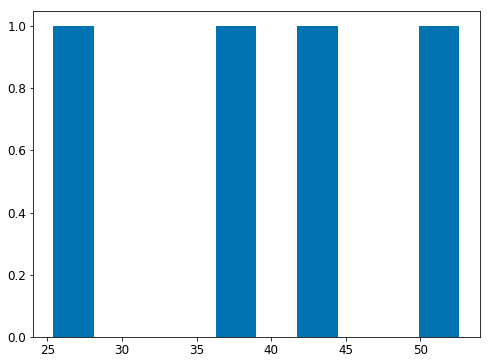

In [156]:
plt.hist(numaxes/numax_errs)

In [157]:
new_table['Object'].pprint(max_lines=40)

  Object  
----------
BD+43_3171
 HD_174020
 HD_180682
 HD_181022


In [158]:
output = Table({'Object':new_table['Object'],
                'numax':numaxes,
                'numax_err':numax_errs,
                'log_g':log_g,
                'log_g_err':log_g_err})
output = output['Object','numax','numax_err','log_g','log_g_err']
output.write('pope_asteroseismology_newtargs_again.csv',format='csv')

In [159]:
output

Object,numax,numax_err,log_g,log_g_err
str10,float64,float64,float64,float64
BD+43_3171,1.984298734336489,0.05145104900196677,1.13655873189138,0.01128193745604834
HD_174020,2.47548965209216,0.09744999575175439,1.240121133701002,0.017048172778136854
HD_180682,3.6778316522927974,0.08410834299831177,1.428401832259337,0.009950160320740798
HD_181022,1.5797194213025423,0.03001747762631546,1.0316087883495522,0.008182072458365292


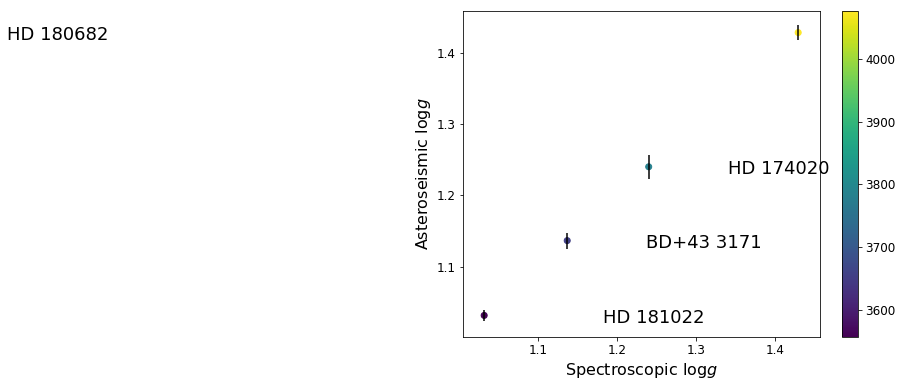

In [160]:
plt.scatter(new_table['logg'],log_g,c=new_table['Teff'])
plt.errorbar(new_table['logg'],log_g,yerr=log_g_err,linestyle='',color='k')
plt.colorbar()
offsets = [0.1,0.1, -1.0,0.15]
for j in range(len(new_table)):
    plt.text(new_table['logg'][j]+offsets[j],log_g[j]-0.01,new_table['Object'][j].replace('_',' '))
# plt.plot(new_table['logg'],new_table['logg'],'-',alpha=0.2)
plt.xlabel(r'Spectroscopic $\log{g}$')
plt.ylabel(r'Asteroseismic $\log{g}$')
plt.savefig('numax_correlation.png')

In [118]:
help(plt.text)

Help on function text in module matplotlib.pyplot:

text(x, y, s, fontdict=None, withdash=False, **kwargs)
    Add text to the axes.
    
    Add the text *s* to the axes at location *x*, *y* in data coordinates.
    
    Parameters
    ----------
    x, y : scalars
        The position to place the text. By default, this is in data
        coordinates. The coordinate system can be changed using the
        *transform* parameter.
    
    s : str
        The text.
    
    fontdict : dictionary, optional, default: None
        A dictionary to override the default text properties. If fontdict
        is None, the defaults are determined by your rc parameters.
    
    withdash : boolean, optional, default: False
        Creates a `~matplotlib.text.TextWithDash` instance instead of a
        `~matplotlib.text.Text` instance.
    
    Returns
    -------
    text : `.Text`
        The created `.Text` instance.
    
    Other Parameters
    ----------------
    **kwargs : `~matplotlib.text

In [22]:
# output

In [23]:
spc_data['Object'].pprint(max_lines=70)

  Object  
----------
BD+42_3150
BD+48_2904
 HD_176209
 HD_182354
 HD_189750


In [24]:
# bad targets BD+433171, HD174020, HD180682 and HD181022
bad = ['BD+43_3171', 'HD_174020', 'HD_180682', 'HD_181022']